# Regrid and smooth ACCESS-OM2 output as initial conditions for MOM6 panan

Uses ACCESS-OM2-01 run year 2 that is close to initial conditions - see run and output here `/g/data/ol01/inputs/regional_boundary_forcing/access-om2-01/01deg_jra55v13_ryf9091/`

Modified from Wilton Aguiar


Is the T-S file from January? Or an average of the year2 ?

Created with an XX Large Mem ARE session with 100GB jobfs

In [3]:
#import cosima_cookbook as cc
#from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob,os
import cmocean.cm as cmocean
import xesmf as xe

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [4]:
client = Client()
client

<Client: 'tcp://127.0.0.1:46135' processes=7 threads=28, memory=126.00 GiB>

Importing data

In [3]:
lat_slice = slice(-90,-50)
Pauthenet_file = '/g/data/ik11/observations/Southern_Ocean_Climatology_PauthenetETAL2021/TS_Climato_Antarctic60S.nc'
WOA_file = '/g/data/ik11/inputs/access-om2/input_20201022/mom_01deg/ocean_temp_salt.res.nc'
Kaihes_file = '/g/data/ik11/users/wf4500/mom6-panAn-iceshelf-tools/initial-conditions/IC_Kaihe/Yamazaki_SO-Monthly-Climatology_v20240604.nc'


#importing data


#PAuthenet surface cell is centered at 10m
Pauthenet = xr.open_mfdataset(Pauthenet_file, parallel = True).sel(lat=lat_slice).isel(time=0)
loncorrected = Pauthenet.lon.where(Pauthenet.lon<=80,(Pauthenet.lon-360))
Pauthenet['lon'] = loncorrected
Pauthenet = Pauthenet.sortby('lon')
Pauthenet_editdepth = xr.concat((Pauthenet.depth.isel(depth=0)* 0,Pauthenet.depth),dim = 'depth').values
Pauthenet = xr.concat((Pauthenet.isel(depth=0),Pauthenet), dim = 'depth')
Pauthenet['depth'] = Pauthenet_editdepth

#Already
WOA = xr.open_mfdataset(WOA_file, parallel = True,chunks = {'GRID_X_T':200,'GRID_Y_T':400}).drop_vars('time').squeeze().sel(GRID_Y_T=slice(-90,-30))
#need to create a halo
WOA =xr.concat((WOA.isel(GRID_X_T=-1),WOA,WOA.isel(GRID_X_T=0)),dim='GRID_X_T')
newlon = WOA.GRID_X_T.values
newlon[0]= ((WOA.GRID_X_T[1]) - ( WOA.GRID_X_T[1:3].diff('GRID_X_T') )).values
newlon[-1]= ((WOA.GRID_X_T[-2]) + ( WOA.GRID_X_T[1:3].diff('GRID_X_T') )).values
WOA['GRID_X_T'] = newlon
##Kaihe surface cell is centered at 5m
Kaihe = xr.open_mfdataset(Kaihes_file, parallel = True).sel(latitude=lat_slice).isel(month=0)
loncorrected = Kaihe.longitude.where(Kaihe.longitude<=80,(Kaihe.longitude-360))
Kaihe['longitude']=loncorrected
Kaihe = Kaihe.sortby('longitude')
Kaihe_editdepth = xr.concat((Kaihe.depth.isel(depth=0)* 0,Kaihe.depth),dim = 'depth').values
Kaihe = xr.concat((Kaihe.isel(depth=0),Kaihe), dim = 'depth')
Kaihe['depth'] = Kaihe_editdepth

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:525: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "GRID_Y_T" starting at index 400. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


Let's now interpolate the data to the OM2 grid

WOA uses **conservative temperature**, is taht what we are using in the model?

# instead of WOA let's use the panan01_IC below which is from ACCESS-OM2 potential temp and is consistent with open boundary conditions files and Wright EOS

In [4]:
panan01_supergrid = xr.open_mfdataset('/g/data/ik11/inputs/mom6/panan/01deg/20230404/ocean_hgrid.nc', parallel = True,chunks = {'nxp':200,'nyp':400})
panan01_IC = xr.open_mfdataset('/g/data/ik11/inputs/mom6/panan/01deg/20230404/forcing/ACCESS-OM2_pottemp_salt_yr2.nc', parallel = True,chunks = {'nxp':200,'nyp':400})

In [5]:
#ocean horizontal grid target:
ocean_hgrid_target_dir = '/g/data/x77/ahg157/inputs/mom6/global-8km/ocean_hgrid.nc'
ocean_vgrid_target_dir = '/g/data/ik11/inputs/mom6/panan/01deg/20230404/forcing/ACCESS-OM2_pottemp_salt_yr2.nc'
ocean_hgrid_target = xr.open_mfdataset(ocean_hgrid_target_dir, parallel = True,chunks = {'nxp':200,'nyp':400})
ocean_vgrid_target =  xr.open_mfdataset('/g/data/ik11/inputs/mom6/panan/01deg/20230404/forcing/ACCESS-OM2_pottemp_salt_yr2.nc', parallel = True).depth

In [6]:
#interpoalting temp to the IC grid
lat_yslice = slice(0,2885) #to cur the ygrid in 37 S - talk to Helen and others about the grid cutup (I currently set it in -37.46271512)
#ocean_hgrid_target_SO = ocean_hgrid_target.isel(nyp=slice(0,2885))
ocean_hgrid_target_SO = ocean_hgrid_target.isel(nxp=slice(1, None, 2), nyp=slice(1, 2885, 2))
data_in = panan01_IC.copy()

In [7]:
#for copying attributes
mom6_01_for_attributes = xr.open_dataset('/g/data/ik11/inputs/mom6/panan/01deg/20230404/forcing/ACCESS-OM2_pottemp_salt_yr2.nc')

In [8]:
panan01_IC

<xarray.Dataset> Size: 4GB
Dimensions:  (depth: 75, nxp: 3600, nyp: 845)
Coordinates:
  * depth    (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * nxp      (nxp) float64 29kB -280.0 -279.9 -279.8 ... 79.72 79.82 79.92
  * nyp      (nyp) float64 7kB -81.1 -81.06 -81.01 ... -37.28 -37.2 -37.12
Data variables:
    salt     (depth, nyp, nxp) float64 2GB dask.array<chunksize=(75, 400, 200), meta=np.ndarray>
    temp     (depth, nyp, nxp) float64 2GB dask.array<chunksize=(75, 400, 200), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear
    history:        Thu Sep 16 10:34:28 2021: ncks -d nyp,,,2 -d nxp,,,2 temp...
    NCO:            netCDF Operators version 4.9.2 (Homepage = http://nco.sf....

In [9]:
%%time
#interpolating temp and salt
panan01_IC_for_8km =panan01_IC.interp(nxp =ocean_hgrid_target_SO.x, nyp = ocean_hgrid_target_SO.y,method = 'nearest').bfill('depth').ffill('depth').bfill('nyp').bfill('nxp').ffill('nxp')#.drop({'GRID_X_T','GRID_Y_T'})
#need to substitude fake counting dimensions by actual values
panan01_IC_for_8km['nyp'] = ocean_hgrid_target_SO.isel(nxp=0).y.values
panan01_IC_for_8km['nyp'].attrs = mom6_01_for_attributes.nyp.attrs
panan01_IC_for_8km['nxp'] = ocean_hgrid_target_SO.isel(nyp=0).x.values
panan01_IC_for_8km['nxp'].attrs = mom6_01_for_attributes.nxp.attrs
panan01_IC_for_8km['temp'].attrs = mom6_01_for_attributes.temp.attrs
panan01_IC_for_8km['salt'].attrs = mom6_01_for_attributes.salt.attrs
panan01_IC_for_8km['depth']=mom6_01_for_attributes.depth

CPU times: user 2.48 s, sys: 336 ms, total: 2.81 s
Wall time: 3.75 s


In [10]:
panan01_IC_for_8km.nyp.max().values,panan01_IC_for_8km.nyp.size

(array(-37.49578069), 1442)

In [11]:
#add some metadata
panan01_IC_for_8km['temp'].attrs = {'label':'potential temperature'}
panan01_IC_for_8km['salt'].attrs = {'label':'practical salinity'}
panan01_IC_for_8km.attrs = {'description':'Regridded for 8km model grid from COSIMA mom6-panan model input /g/data/ik11/inputs/mom6/panan/01deg/20230404/forcing/ACCESS-OM2_pottemp_salt_yr2.nc. Originally obtained from COSIMA ACCESS-OM2-01 year 2 output. See notebook https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/main/initial-conditions/ACCESSOM2_IC_into_8km_grid.ipynb'}
                            

In [12]:
panan01_IC_for_8km

<xarray.Dataset> Size: 7GB
Dimensions:  (depth: 75, nxp: 4320, nyp: 1442)
Coordinates:
  * depth    (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * nxp      (nxp) float64 35kB -280.0 -279.9 -279.8 ... 79.79 79.88 79.96
  * nyp      (nyp) float64 12kB -86.49 -86.47 -86.45 ... -37.63 -37.56 -37.5
Data variables:
    salt     (depth, nyp, nxp) float64 4GB dask.array<chunksize=(75, 200, 100), meta=np.ndarray>
    temp     (depth, nyp, nxp) float64 4GB dask.array<chunksize=(75, 200, 100), meta=np.ndarray>
Attributes:
    description:  Regridded for 8km model grid from COSIMA mom6-panan model i...

In [13]:
%%time
panan01_IC_for_8km = panan01_IC_for_8km.load()

CPU times: user 54.3 s, sys: 16.9 s, total: 1min 11s
Wall time: 2min 26s


In [47]:
# not used - is really slow??
# import xesmf as xe

# # target grid (t points)
# dg = xr.open_dataset("/g/data/x77/ahg157/inputs/mom6/global-8km/ocean_hgrid.nc").isel(nyp=slice(0,2885))
# dg = (
#     dg[["x", "y"]]
#     .isel(nxp=slice(1, None, 2), nyp=slice(1, None, 2))
#     .rename(x="lon", y="lat")
# )

# regridder = xe.Regridder(
#     data_in.rename(GRID_X_T="lon", GRID_Y_T="lat"),
#     dg,
#     "bilinear",
#     periodic=True,
#     reuse_weights=False,
#     filename="bilinear_init_weights.nc",
# )

In [5]:
enc_TS = {
    "_FillValue": -1.e-20,
    # "zlib": True,
    # "shuffle": True,
    # "complevel": 1,
}

#panan01_IC_for_8km.to_netcdf("/g/data/x77/cy8964/mom6/input/input-8km/ACCESS-OM2_IC_bfilled.nc", encoding={"temp": enc_TS, "salt": enc_TS})


In [24]:
target_depth = 500

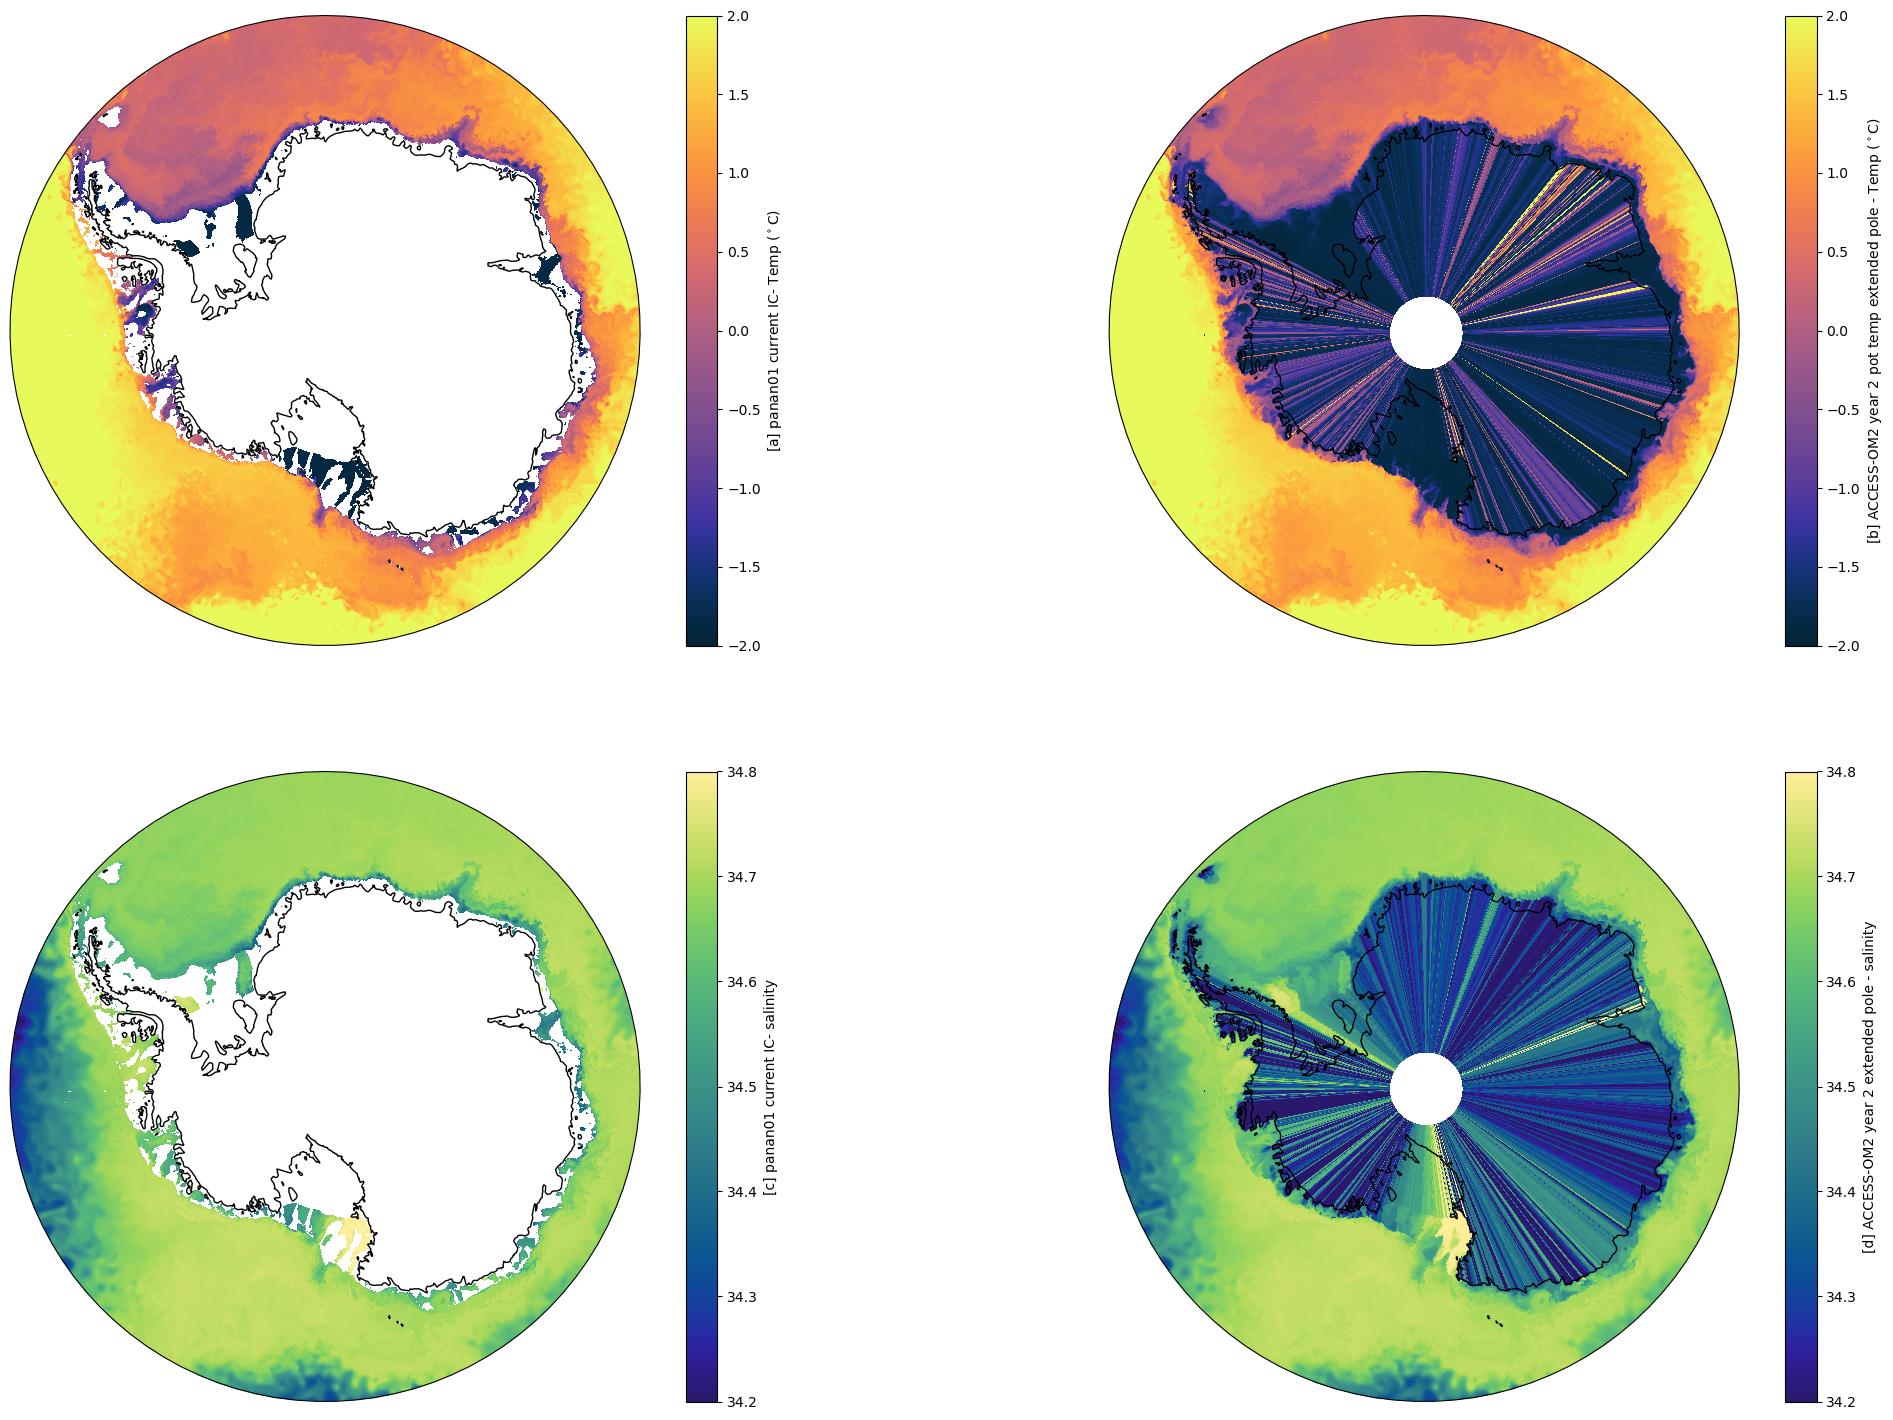

In [25]:
# import some useful packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from dask.distributed import Client
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.path as mpath



temp_min = -2#np.round(WOA.temp.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').min(),1)
temp_max = 2#np.round(WOA.temp.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).max(),1) 
salt_max = 34.8#np.round(WOA.salt.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).max(),1) #33.5
salt_min = 34.2#np.round(WOA.salt.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).min(),1) #34.5
projection = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(26,18))
ax = fig.add_subplot(2,2,1,projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


plt.pcolormesh(panan01_IC.nxp,
               panan01_IC.nyp,
               panan01_IC.temp.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = temp_min, vmax = temp_max, cmap = cmo.thermal)
plt.colorbar(label = '[a] panan01 current IC- Temp ($^\circ$C)')



ax222 = fig.add_subplot(2,2,2,projection=projection)
ax222.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax222.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax222.set_boundary(circle, transform=ax222.transAxes)


plt.pcolormesh(panan01_IC_for_8km.nxp,
               panan01_IC_for_8km.nyp,
               panan01_IC_for_8km.temp.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = temp_min, vmax = temp_max, cmap =  cmo.thermal)
plt.colorbar(label = '[b] ACCESS-OM2 year 2 pot temp extended pole - Temp ($^\circ$C)')


ax223 = fig.add_subplot(2,2,3,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)



plt.pcolormesh(panan01_IC.nxp,
               panan01_IC.nyp,
               panan01_IC.salt.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = salt_min, vmax = salt_max, cmap = cmo.haline)
plt.colorbar(label = '[c] panan01 current IC- salinity')





ax223 = fig.add_subplot(2,2,4,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)




plt.pcolormesh(panan01_IC_for_8km.nxp,
               panan01_IC_for_8km.nyp,
               panan01_IC_for_8km.salt.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(),vmin = salt_min, vmax = salt_max, cmap =  cmo.haline)
plt.colorbar(label = '[d] ACCESS-OM2 year 2 extended pole - salinity')




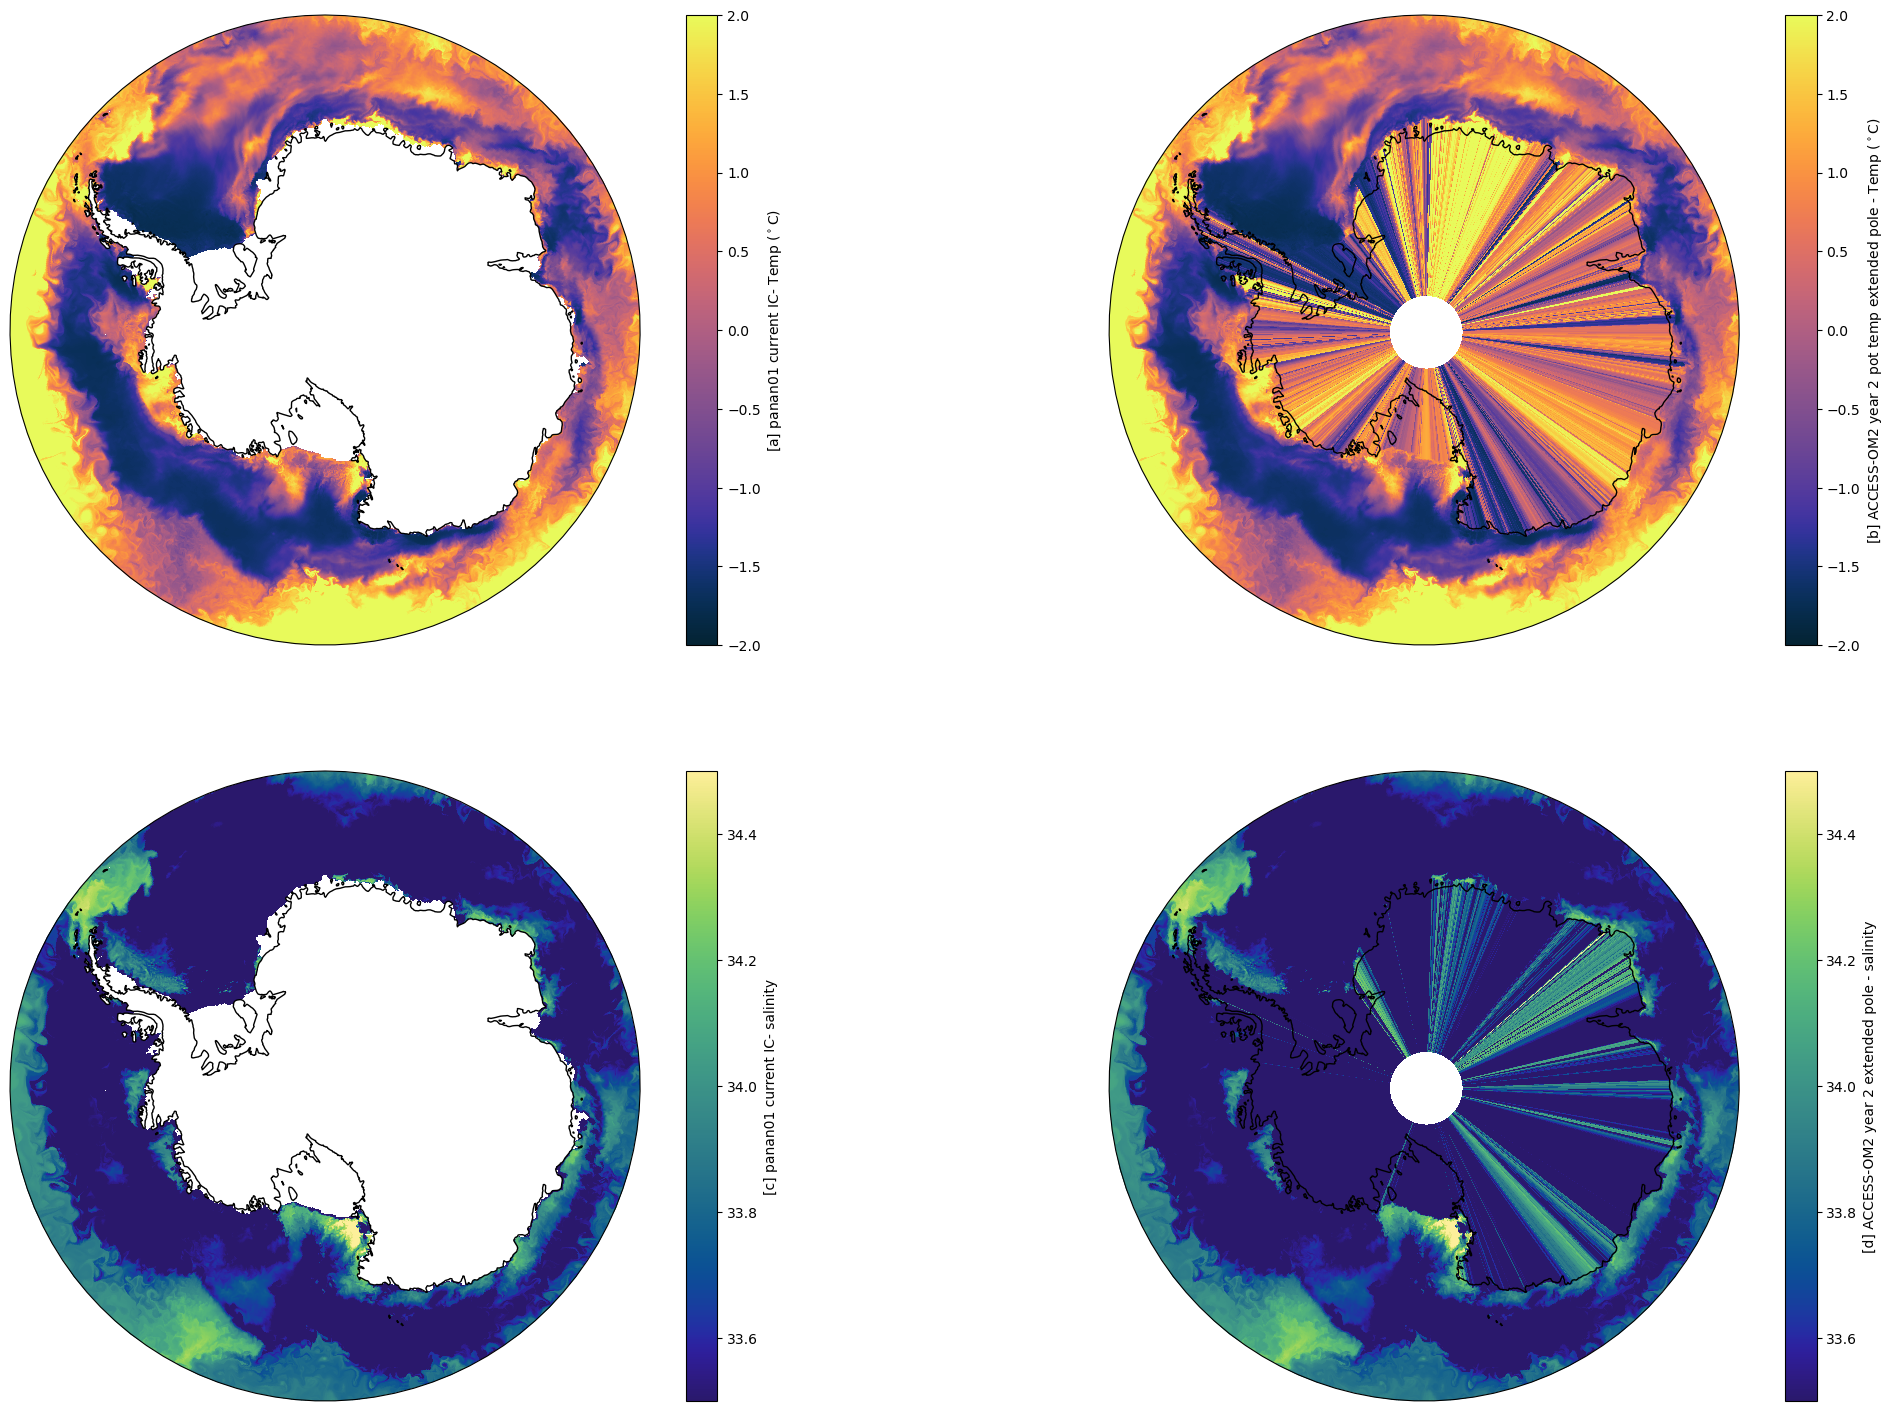

In [76]:
target_depth = 0


temp_min = -2#np.round(WOA.temp.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').min(),1)
temp_max = 2#np.round(WOA.temp.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).max(),1) 
salt_max = 34.5#np.round(WOA.salt.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).max(),1) #33.5
salt_min = 33.5#np.round(WOA.salt.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).min(),1) #34.5
projection = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(26,18))
ax = fig.add_subplot(2,2,1,projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


plt.pcolormesh(panan01_IC.nxp,
               panan01_IC.nyp,
               panan01_IC.temp.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = temp_min, vmax = temp_max, cmap = cmo.thermal)
plt.colorbar(label = '[a] panan01 current IC- Temp ($^\circ$C)')



ax222 = fig.add_subplot(2,2,2,projection=projection)
ax222.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax222.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax222.set_boundary(circle, transform=ax222.transAxes)


plt.pcolormesh(panan01_IC_for_8km.nxp,
               panan01_IC_for_8km.nyp,
               panan01_IC_for_8km.temp.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = temp_min, vmax = temp_max, cmap =  cmo.thermal)
plt.colorbar(label = '[b] ACCESS-OM2 year 2 pot temp extended pole - Temp ($^\circ$C)')


ax223 = fig.add_subplot(2,2,3,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)



plt.pcolormesh(panan01_IC.nxp,
               panan01_IC.nyp,
               panan01_IC.salt.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = salt_min, vmax = salt_max, cmap = cmo.haline)
plt.colorbar(label = '[c] panan01 current IC- salinity')





ax223 = fig.add_subplot(2,2,4,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)




plt.pcolormesh(panan01_IC_for_8km.nxp,
               panan01_IC_for_8km.nyp,
               panan01_IC_for_8km.salt.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(),vmin = salt_min, vmax = salt_max, cmap =  cmo.haline)
plt.colorbar(label = '[d] ACCESS-OM2 year 2 extended pole - salinity')




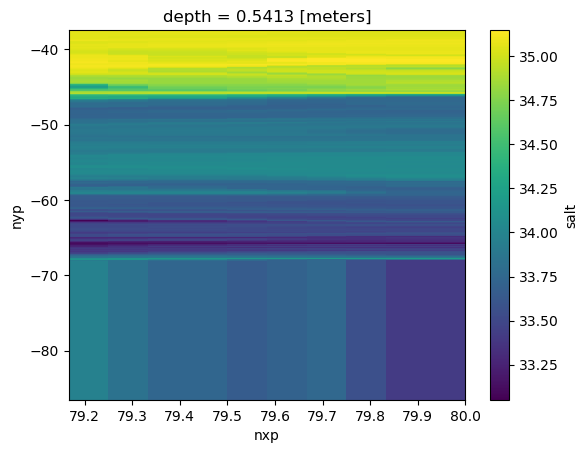

In [77]:
panan01_IC_for_8km.salt.isel(nxp = np.arange(-10,0)).isel(depth = 0).plot()

_______________________________

## Longitude-smoothed version on land

Out of curiosity, I can try to just befille horzontally, or smooth the continent to see if the Bellingshausen leakage is fixed

In [16]:
ocean_mask_target_dir = '/g/data/x77/ahg157/inputs/mom6/global-8km/ocean_mask.nc'
ocean_mask_target = xr.open_mfdataset(ocean_mask_target_dir,parallel = True, chunks = {'depth':20,'nx':200}).isel(ny=slice(0,1442)).\
mask.rename({'nx':'nxp','ny':'nyp'})
ocean_mask_target['nxp'] = panan01_IC_for_8km.nxp.values
ocean_mask_target['nyp'] = panan01_IC_for_8km.nyp.values
ocean_mask_target_land = ocean_mask_target.where(ocean_mask_target==0)+1
ocean_mask_target_ocean = ocean_mask_target.where(ocean_mask_target==1)

In [17]:
#creating fuzzy weights in boundary for stiching
weights_for_nonsmoothed = ocean_mask_target_land.copy()
offset=50 #normal is 50
minweight=0.00001
weights_for_nonsmoothed[0:(1134-offset),:] = (weights_for_nonsmoothed[offset:1134,:]-minweight).values
weights_for_nonsmoothed = (weights_for_nonsmoothed).fillna(0)
weights_for_nonsmoothed = ocean_mask_target_land - weights_for_nonsmoothed
weights_for_nonsmoothed[1115:,:] =weights_for_nonsmoothed[1115:,:]*0 +1
weights_for_nonsmoothed = weights_for_nonsmoothed.where(weights_for_nonsmoothed<0.99)
weights_for_nonsmoothed = weights_for_nonsmoothed.fillna(0) + ocean_mask_target_ocean.fillna(0)
weights_for_nonsmoothed = weights_for_nonsmoothed.where(weights_for_nonsmoothed>0)
weights_for_nonsmoothed[1115:,:] =weights_for_nonsmoothed[1115:,:].fillna(1)
weights_for_nonsmoothed = weights_for_nonsmoothed.interpolate_na(dim='nyp', method="linear", fill_value="extrapolate")
weights_for_smoothed = 1 - weights_for_nonsmoothed

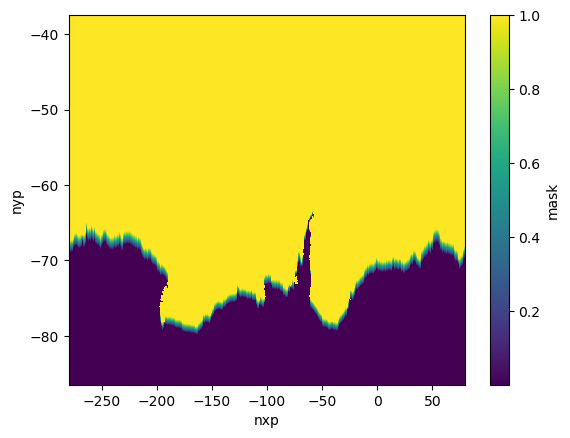

In [18]:
weights_for_nonsmoothed.plot()

Regions above with mask = 1 will fully have ocean data from WOA. Regions with mask <1 have the smoothed bottom filled data. Fuzzy boundary with the range between 0 and 1 representing the level of smoothing applied ( 0 is the highest smoothing).

Smoothing is purely zonal, and window for smoothing is set up in the next cells




In [19]:
panan01_IC_for_8km_2 = panan01_IC_for_8km.copy()
#Line below can be omitted or maintained by choice. it just assure we are only smoothing the land moints, to avoint offshore points to leak zonally into the shelf
panan01_IC_for_8km_2 = (panan01_IC_for_8km_2* (ocean_mask_target.where(ocean_mask_target==0)+1)).ffill('nyp')

panan01_IC_for_8km_2  =xr.concat((panan01_IC_for_8km_2.isel(nxp=slice(-500,-1)),panan01_IC_for_8km_2 ,panan01_IC_for_8km_2.isel(nxp=slice(0,500))),dim='nxp')
newlon = panan01_IC_for_8km_2.nxp.values
newlon[0:499]= np.sort(((panan01_IC_for_8km_2.nxp[1:500]* 0 + panan01_IC_for_8km_2.nxp.min()) - ( panan01_IC_for_8km_2.nxp[1:3].diff('nxp').values*(panan01_IC_for_8km_2.nxp[1:500]* 0+1) ).cumsum()[::-1]))
newlon[-500:]= np.sort(((panan01_IC_for_8km_2.nxp[-500:]* 0 + panan01_IC_for_8km_2.nxp.max()) + ( panan01_IC_for_8km_2.nxp[1:3].diff('nxp').values*(panan01_IC_for_8km_2.nxp[-500:]* 0+1) ).cumsum()[::-1]))
panan01_IC_for_8km_2['nxp'] = newlon

On the line below you can choose to do a zonal + meridional, or solely zonal smoothing

In [20]:
#WOA smoothed full domain. mask will be applied later
nxwindow = 600 #600 (approx 0.138*nxp)seems to be quite good the 8km model. This will have to be adjusted for a higher res model
nywindow = 10
# WOA_IC_for_8km_smoothed_land = (WOA_IC_for_8km).rolling(nxp=nxwindow,min_periods=1).mean()\
# .rolling(nyp=nywindow,min_periods=1).mean()* ocean_mask_target_land #zonal and meridional smoothing
panan01_IC_for_8km_smoothed_land = (panan01_IC_for_8km_2).rolling(nxp=nxwindow,min_periods=1,center=True).mean() * ocean_mask_target_land #zonal smoothing alone
panan01_IC_for_8km_nonsmoothed_land = (panan01_IC_for_8km_2)* ocean_mask_target_land

panan01_IC_for_8km_smoothed_land = (panan01_IC_for_8km_smoothed_land*weights_for_smoothed) + (panan01_IC_for_8km_nonsmoothed_land*weights_for_nonsmoothed)
# #below with ice shelves smoothed
panan01_IC_for_8km_smoothed = panan01_IC_for_8km_smoothed_land.fillna(0) + (panan01_IC_for_8km *ocean_mask_target_ocean).fillna(0)



In [21]:
panan01_IC_for_8km_smoothed = panan01_IC_for_8km_smoothed.load()

In [26]:
target_depth = 0

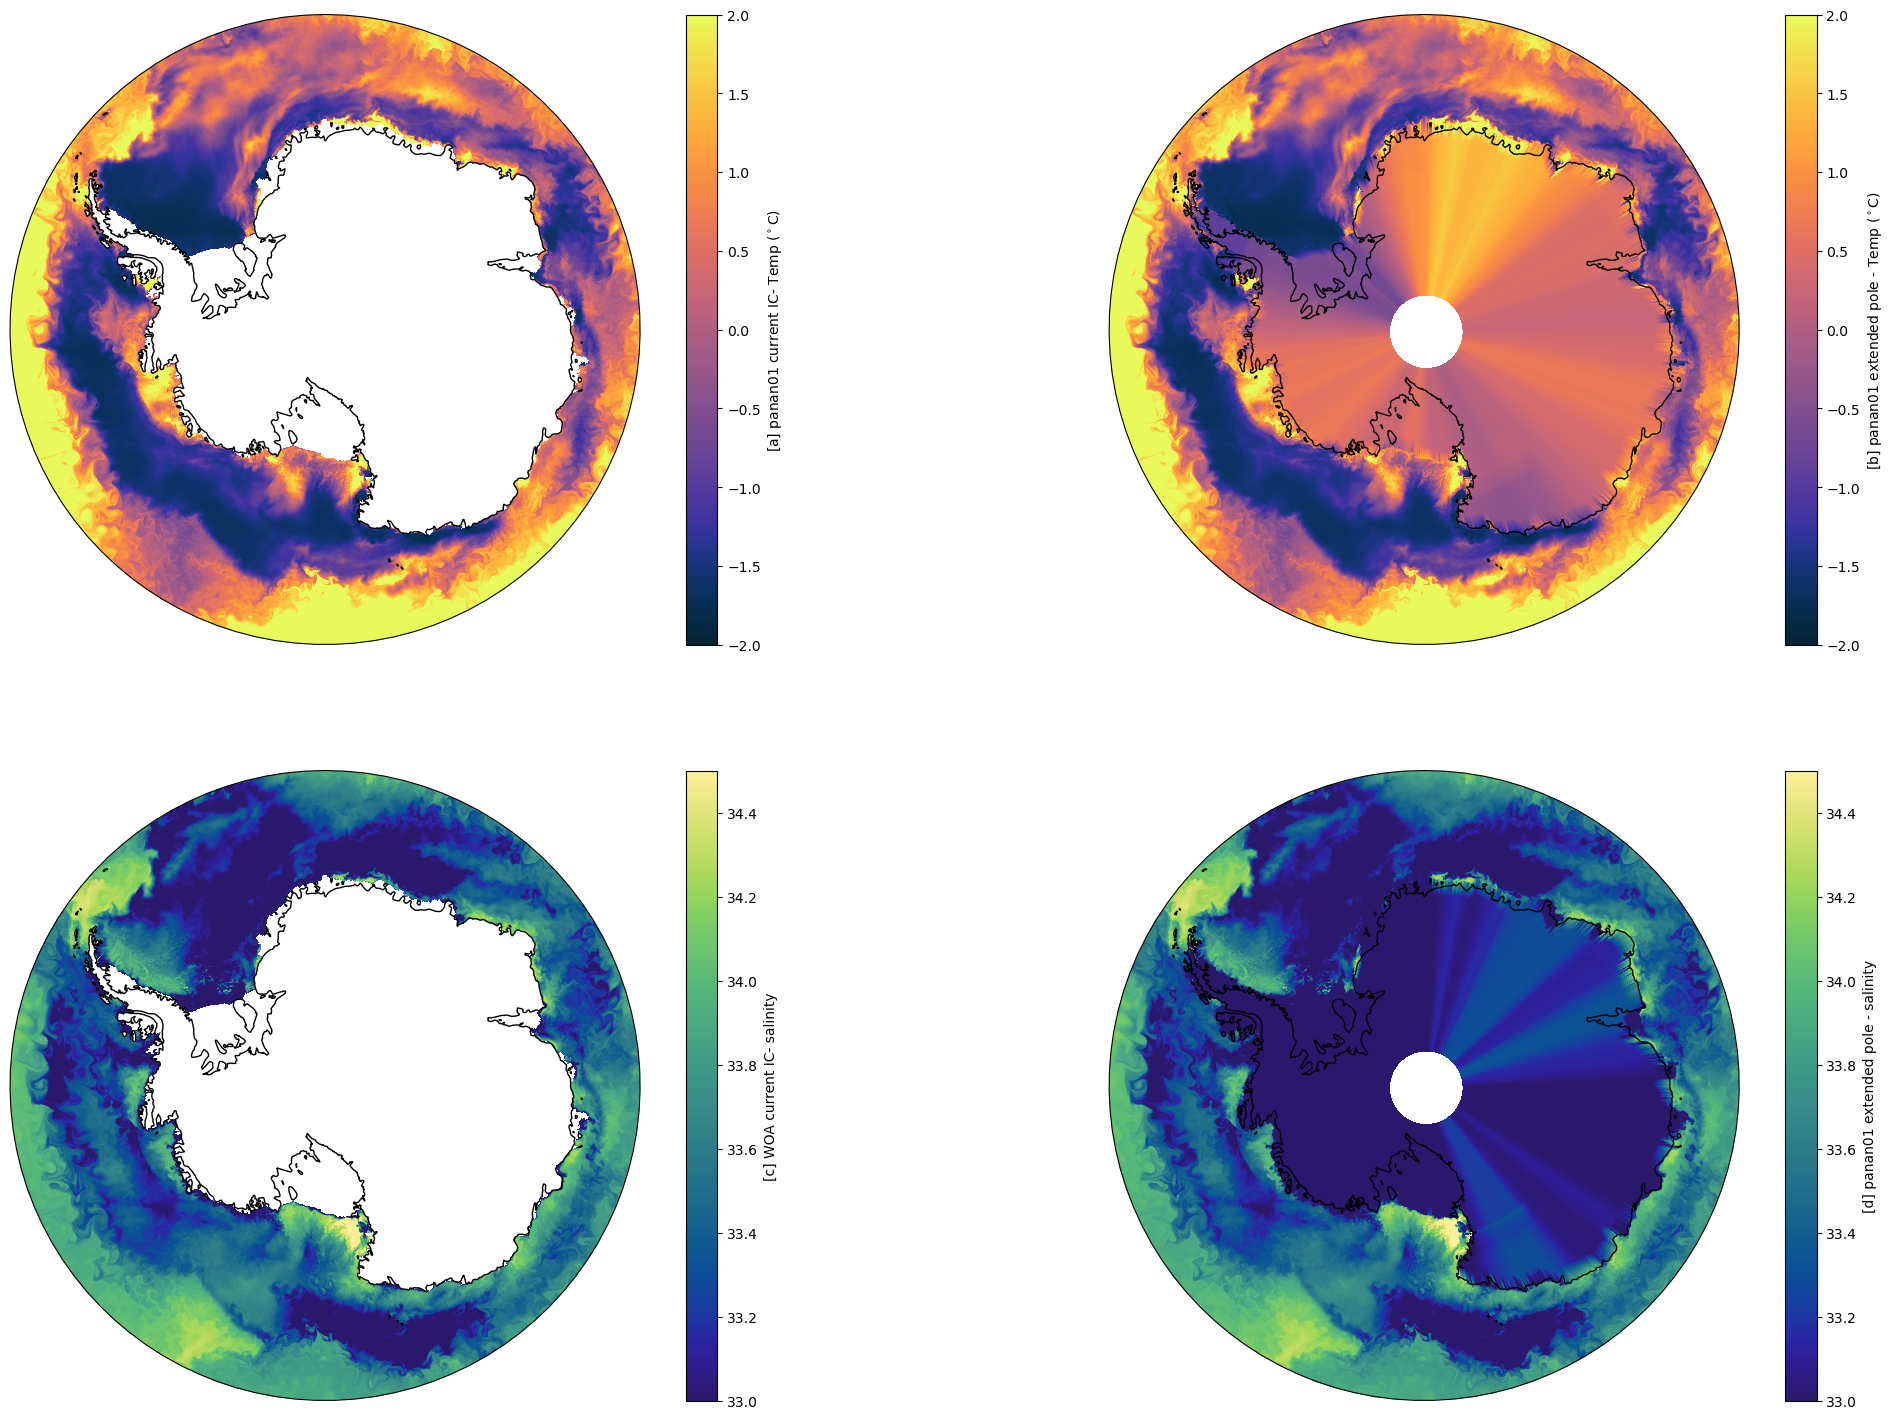

In [27]:


temp_min = -2#np.round(WOA.temp.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').min(),1)
temp_max = 2#np.round(WOA.temp.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).max(),1) 
salt_max = 34.5#np.round(WOA.salt.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).max(),1) #33.5
salt_min = 33#np.round(WOA.salt.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).min(),1) #34.5
projection = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(26,18))
ax = fig.add_subplot(2,2,1,projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


plt.pcolormesh(panan01_IC.nxp,
               panan01_IC.nyp,
               panan01_IC.temp.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = temp_min, vmax = temp_max, cmap = cmo.thermal)
plt.colorbar(label = '[a] panan01 current IC- Temp ($^\circ$C)')



ax222 = fig.add_subplot(2,2,2,projection=projection)
ax222.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax222.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax222.set_boundary(circle, transform=ax222.transAxes)


plt.pcolormesh(panan01_IC_for_8km_smoothed.nxp,
               panan01_IC_for_8km_smoothed.nyp,
               panan01_IC_for_8km_smoothed.temp.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = temp_min, vmax = temp_max, cmap =  cmo.thermal)
plt.colorbar(label = '[b] panan01 extended pole - Temp ($^\circ$C)')


ax223 = fig.add_subplot(2,2,3,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)



plt.pcolormesh(panan01_IC.nxp,
               panan01_IC.nyp,
               panan01_IC.salt.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = salt_min, vmax = salt_max, cmap = cmo.haline)
plt.colorbar(label = '[c] WOA current IC- salinity')





ax223 = fig.add_subplot(2,2,4,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)




plt.pcolormesh(panan01_IC_for_8km_smoothed.nxp,
               panan01_IC_for_8km_smoothed.nyp,
               panan01_IC_for_8km_smoothed.salt.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(),vmin = salt_min, vmax = salt_max, cmap =  cmo.haline)
plt.colorbar(label = '[d] panan01 extended pole - salinity')



In [85]:
target_depth = 500

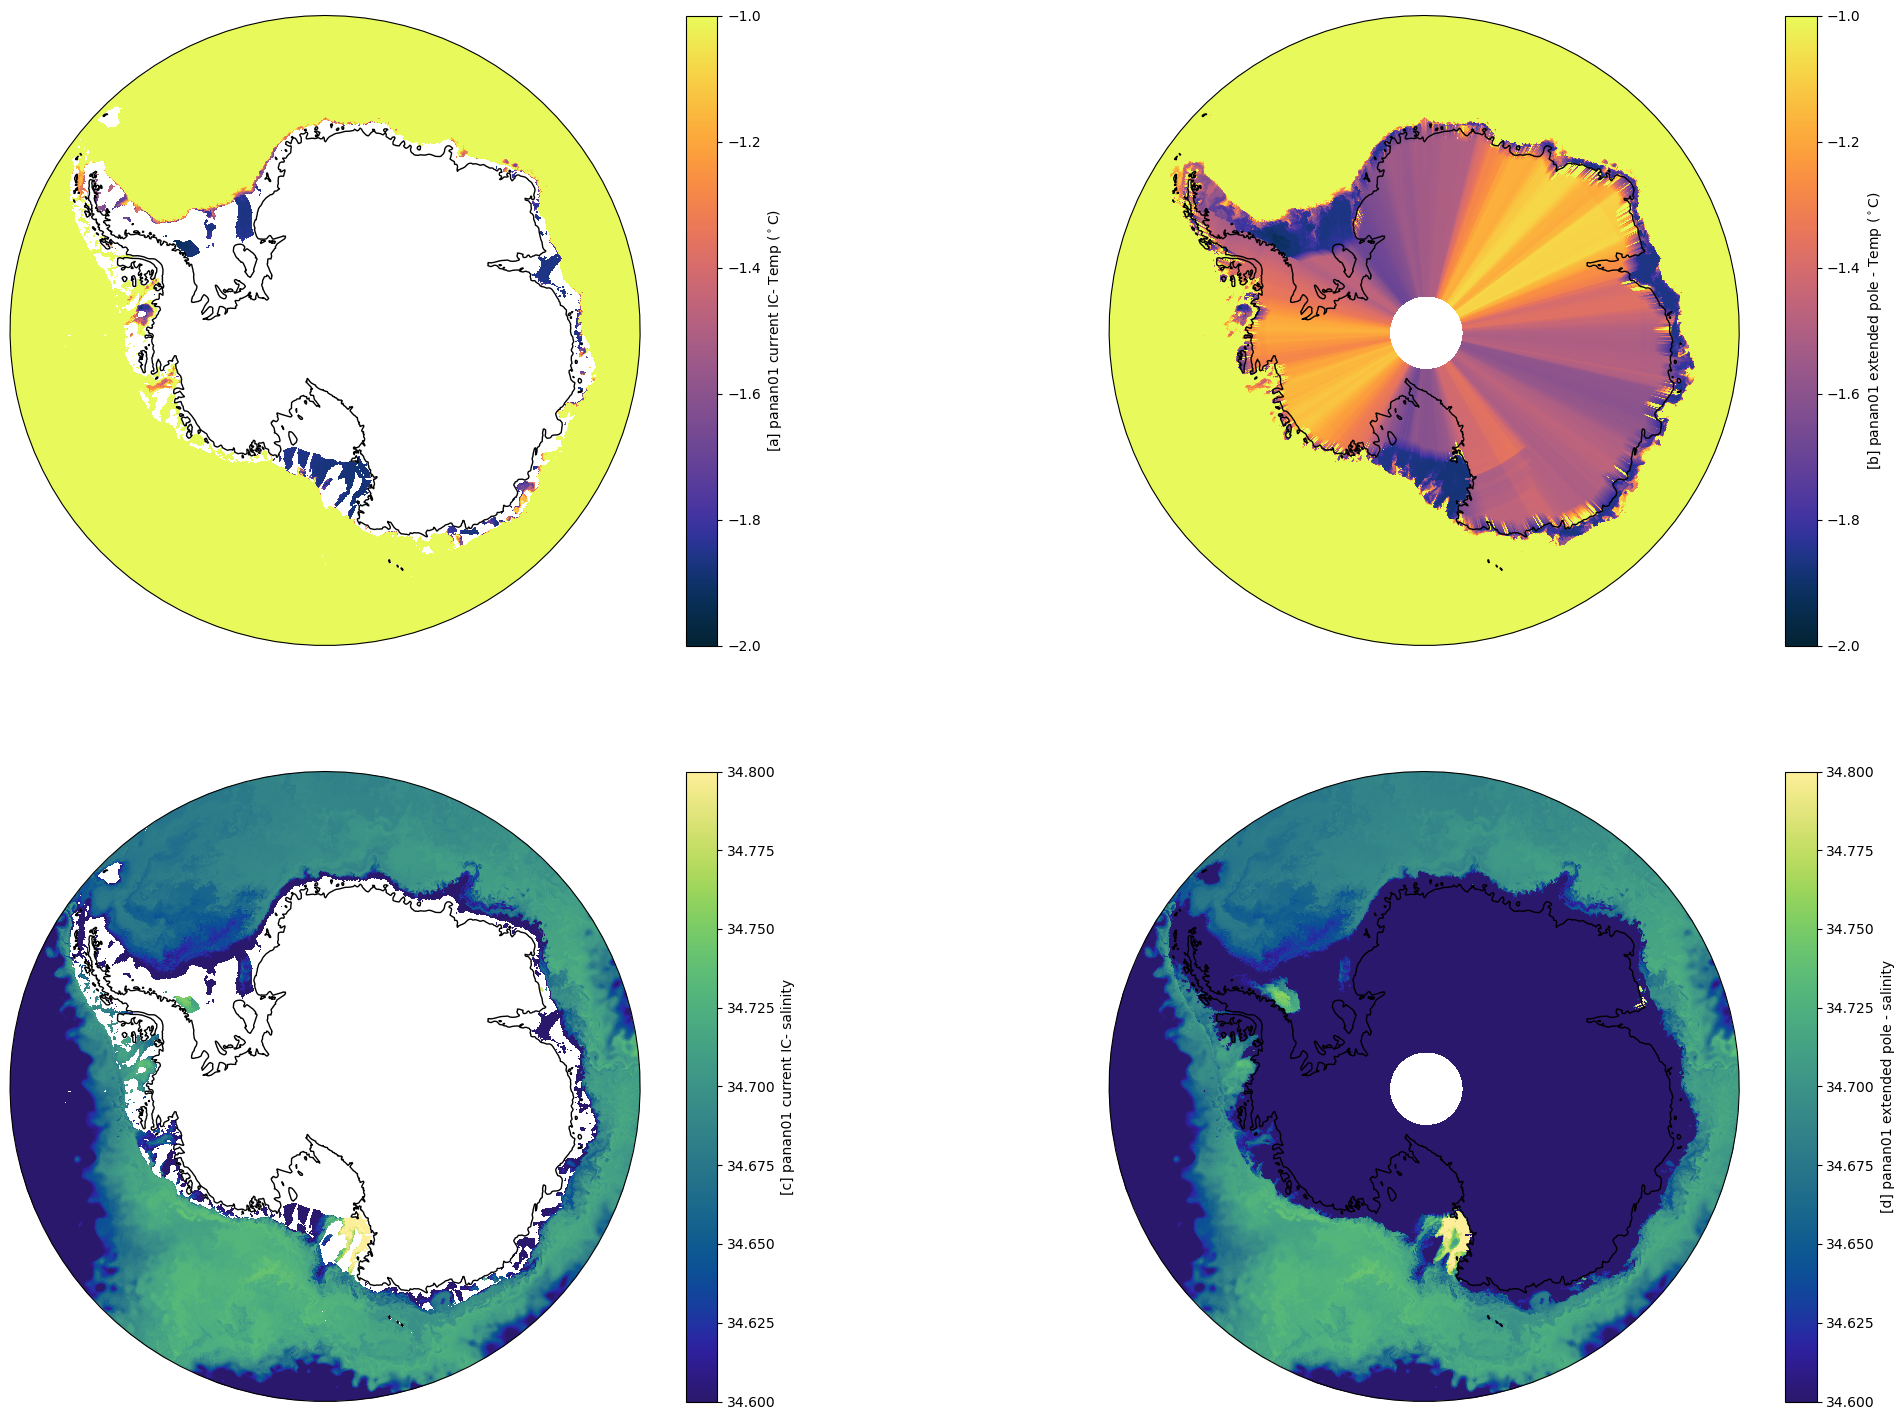

In [86]:
temp_min = -2#np.round(WOA.temp.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').min(),1)
temp_max = -1#np.round(WOA.temp.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).max(),1) 
salt_max = 34.8#np.round(WOA.salt.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).max(),1) #33.5
salt_min = 34.6#np.round(WOA.salt.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).min(),1) #34.5
projection = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(26,18))
ax = fig.add_subplot(2,2,1,projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


plt.pcolormesh(panan01_IC.nxp,
               panan01_IC.nyp,
               panan01_IC.temp.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = temp_min, vmax = temp_max, cmap = cmo.thermal)
plt.colorbar(label = '[a] panan01 current IC- Temp ($^\circ$C)')



ax222 = fig.add_subplot(2,2,2,projection=projection)
ax222.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax222.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax222.set_boundary(circle, transform=ax222.transAxes)


plt.pcolormesh(panan01_IC_for_8km_smoothed.nxp,
               panan01_IC_for_8km_smoothed.nyp,
               panan01_IC_for_8km_smoothed.temp.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = temp_min, vmax = temp_max, cmap =  cmo.thermal)
plt.colorbar(label = '[b] panan01 extended pole - Temp ($^\circ$C)')


ax223 = fig.add_subplot(2,2,3,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)



plt.pcolormesh(panan01_IC.nxp,
               panan01_IC.nyp,
               panan01_IC.salt.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = salt_min, vmax = salt_max, cmap = cmo.haline)
plt.colorbar(label = '[c] panan01 current IC- salinity')





ax223 = fig.add_subplot(2,2,4,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)




plt.pcolormesh(panan01_IC_for_8km_smoothed.nxp,
               panan01_IC_for_8km_smoothed.nyp,
               panan01_IC_for_8km_smoothed.salt.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(),vmin = salt_min, vmax = salt_max, cmap =  cmo.haline)
plt.colorbar(label = '[d] panan01 extended pole - salinity')




In [87]:
target_depth = 1000

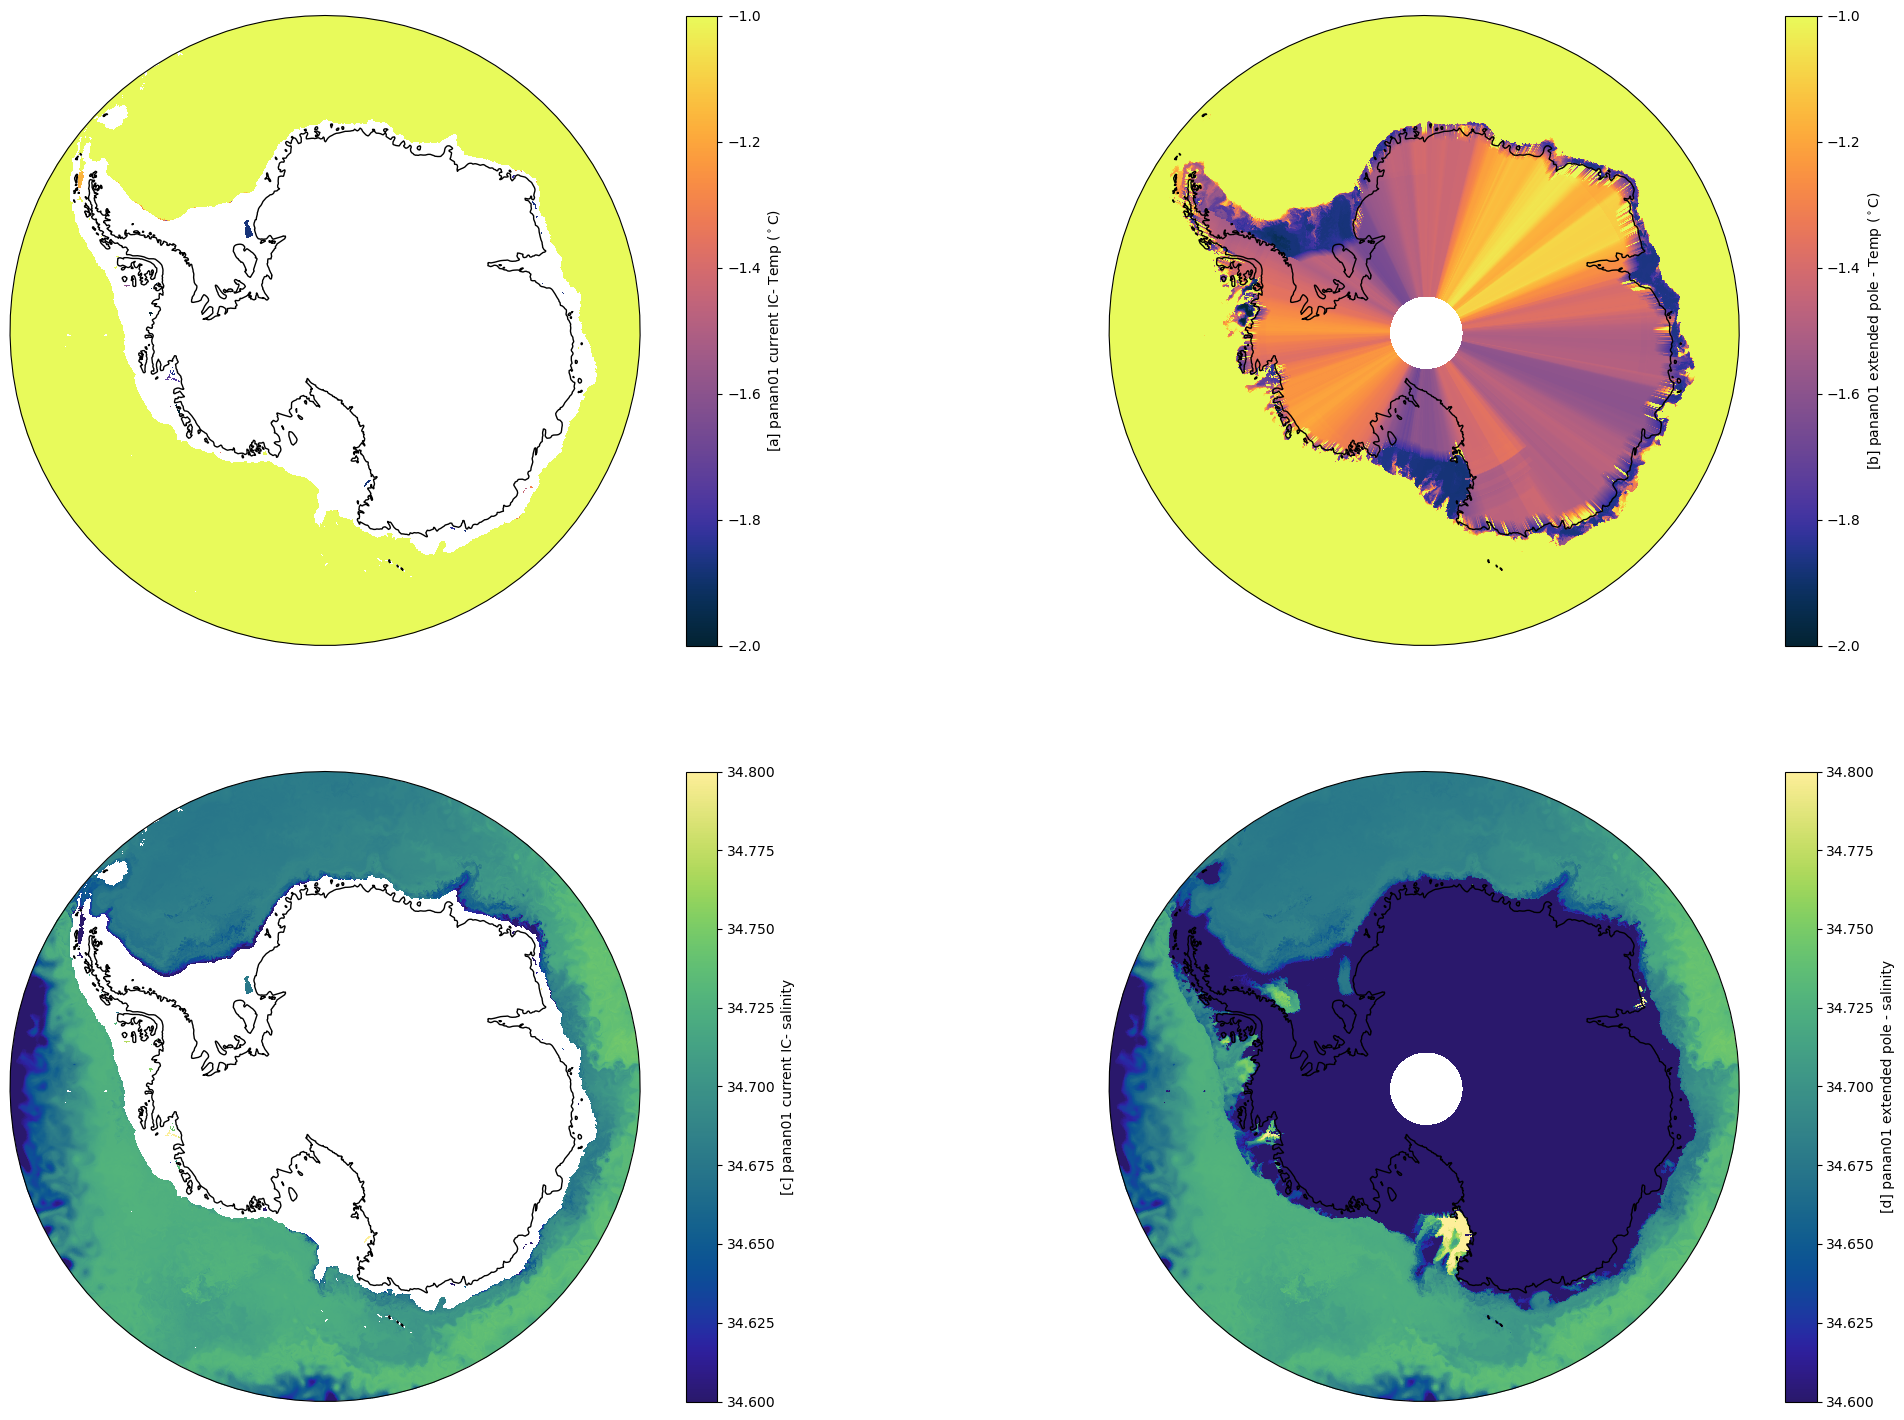

In [88]:
temp_min = -2#np.round(WOA.temp.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').min(),1)
temp_max = -1#np.round(WOA.temp.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).max(),1) 
salt_max = 34.8#np.round(WOA.salt.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).max(),1) #33.5
salt_min = 34.6#np.round(WOA.salt.mean('GRID_X_T').sel(ZT=target_depth,method='nearest').sel(GRID_Y_T=slice(-90,-60)).min(),1) #34.5
projection = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(26,18))
ax = fig.add_subplot(2,2,1,projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


plt.pcolormesh(panan01_IC.nxp,
               panan01_IC.nyp,
               panan01_IC.temp.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = temp_min, vmax = temp_max, cmap = cmo.thermal)
plt.colorbar(label = '[a] panan01 current IC- Temp ($^\circ$C)')



ax222 = fig.add_subplot(2,2,2,projection=projection)
ax222.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax222.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax222.set_boundary(circle, transform=ax222.transAxes)


plt.pcolormesh(panan01_IC_for_8km_smoothed.nxp,
               panan01_IC_for_8km_smoothed.nyp,
               panan01_IC_for_8km_smoothed.temp.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = temp_min, vmax = temp_max, cmap =  cmo.thermal)
plt.colorbar(label = '[b] panan01 extended pole - Temp ($^\circ$C)')


ax223 = fig.add_subplot(2,2,3,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)



plt.pcolormesh(panan01_IC.nxp,
               panan01_IC.nyp,
               panan01_IC.salt.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(), vmin = salt_min, vmax = salt_max, cmap = cmo.haline)
plt.colorbar(label = '[c] panan01 current IC- salinity')





ax223 = fig.add_subplot(2,2,4,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)




plt.pcolormesh(panan01_IC_for_8km_smoothed.nxp,
               panan01_IC_for_8km_smoothed.nyp,
               panan01_IC_for_8km_smoothed.salt.sel(depth=target_depth,method='nearest'),
               transform=ccrs.PlateCarree(),vmin = salt_min, vmax = salt_max, cmap =  cmo.haline)
plt.colorbar(label = '[d] panan01 extended pole - salinity')



In [32]:

panan01_IC_for_8km_smoothed.to_netcdf("/g/data/x77/cy8964/mom6/input/input-8km/ACCESS-OM2_IC_bfilled_smoothedland.nc", encoding={"temp": enc_TS, "salt": enc_TS})


In [6]:
## 25 Aug - resave with metadata
panan01_IC_for_8km_smoothed = xr.open_dataset("/g/data/x77/cy8964/mom6/input/input-8km/ACCESS-OM2_IC_bfilled_smoothedland.nc")
panan01_IC_for_8km_smoothed.attrs["description"] = 'Initial conditions of potential temperature and practical salinity taken from start of Jan of second year of ACCESS-OM2-01-RYF output, restarted from WOA13. Interpolated from 1/10th to 1/12th degree by nearest neighbour interpolation and extended southwards using smoothing to avoid cross-Antarctic peninsula leakage. Notebook https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/claire_working/initial-conditions/ACCESSOM2_IC_into_8km_grid.ipynb'
panan01_IC_for_8km_smoothed.to_netcdf("/g/data/tm70/cy8964/mom6/input/input-8km/ACCESS-OM2_IC_bfilled_smoothedland.nc", encoding={"temp": enc_TS, "salt": enc_TS})


## Transects analysis

We need to check if there is some warm waters leakage to the shelf in this approach. Let's check that using some transects.

In [28]:
lat_slice_forplot=slice(-87,-55)
ocean_topog_target_dir = '/g/data/x77/ahg157/inputs/mom6/global-8km/topog.nc'
ocean_topog_target = xr.open_dataset(ocean_topog_target_dir).isel(ny=slice(0,1442))
ocean_topog_target['ny'] = panan01_IC_for_8km_smoothed.nyp.values
ocean_topog_target['nx'] = panan01_IC_for_8km_smoothed.nxp.values
ocean_topog_target = ocean_topog_target.sel(ny=lat_slice_forplot).depth.fillna(0)

dashed blue line marks the northern start of the extrapolation

(-69.0, -65.0)

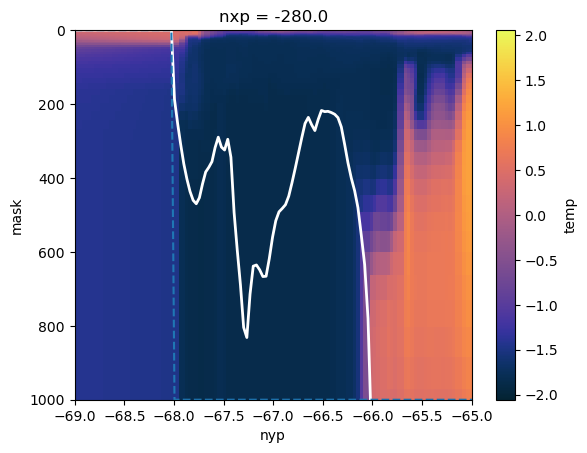

In [29]:
transect_ind = 0

panan01_IC_for_8km_smoothed.temp.isel(nxp=transect_ind).sel(nyp=lat_slice_forplot).plot(y='depth',cmap=cmo.thermal)
ocean_topog_target.isel(nx=transect_ind).plot(x='ny',color='white',linewidth=2)
(1000*ocean_mask_target.isel(nxp=transect_ind)).plot(x='nyp',linestyle='--')
plt.ylim(1000,0)
plt.xlim(-69,-65)

Transects with **smoothed data**

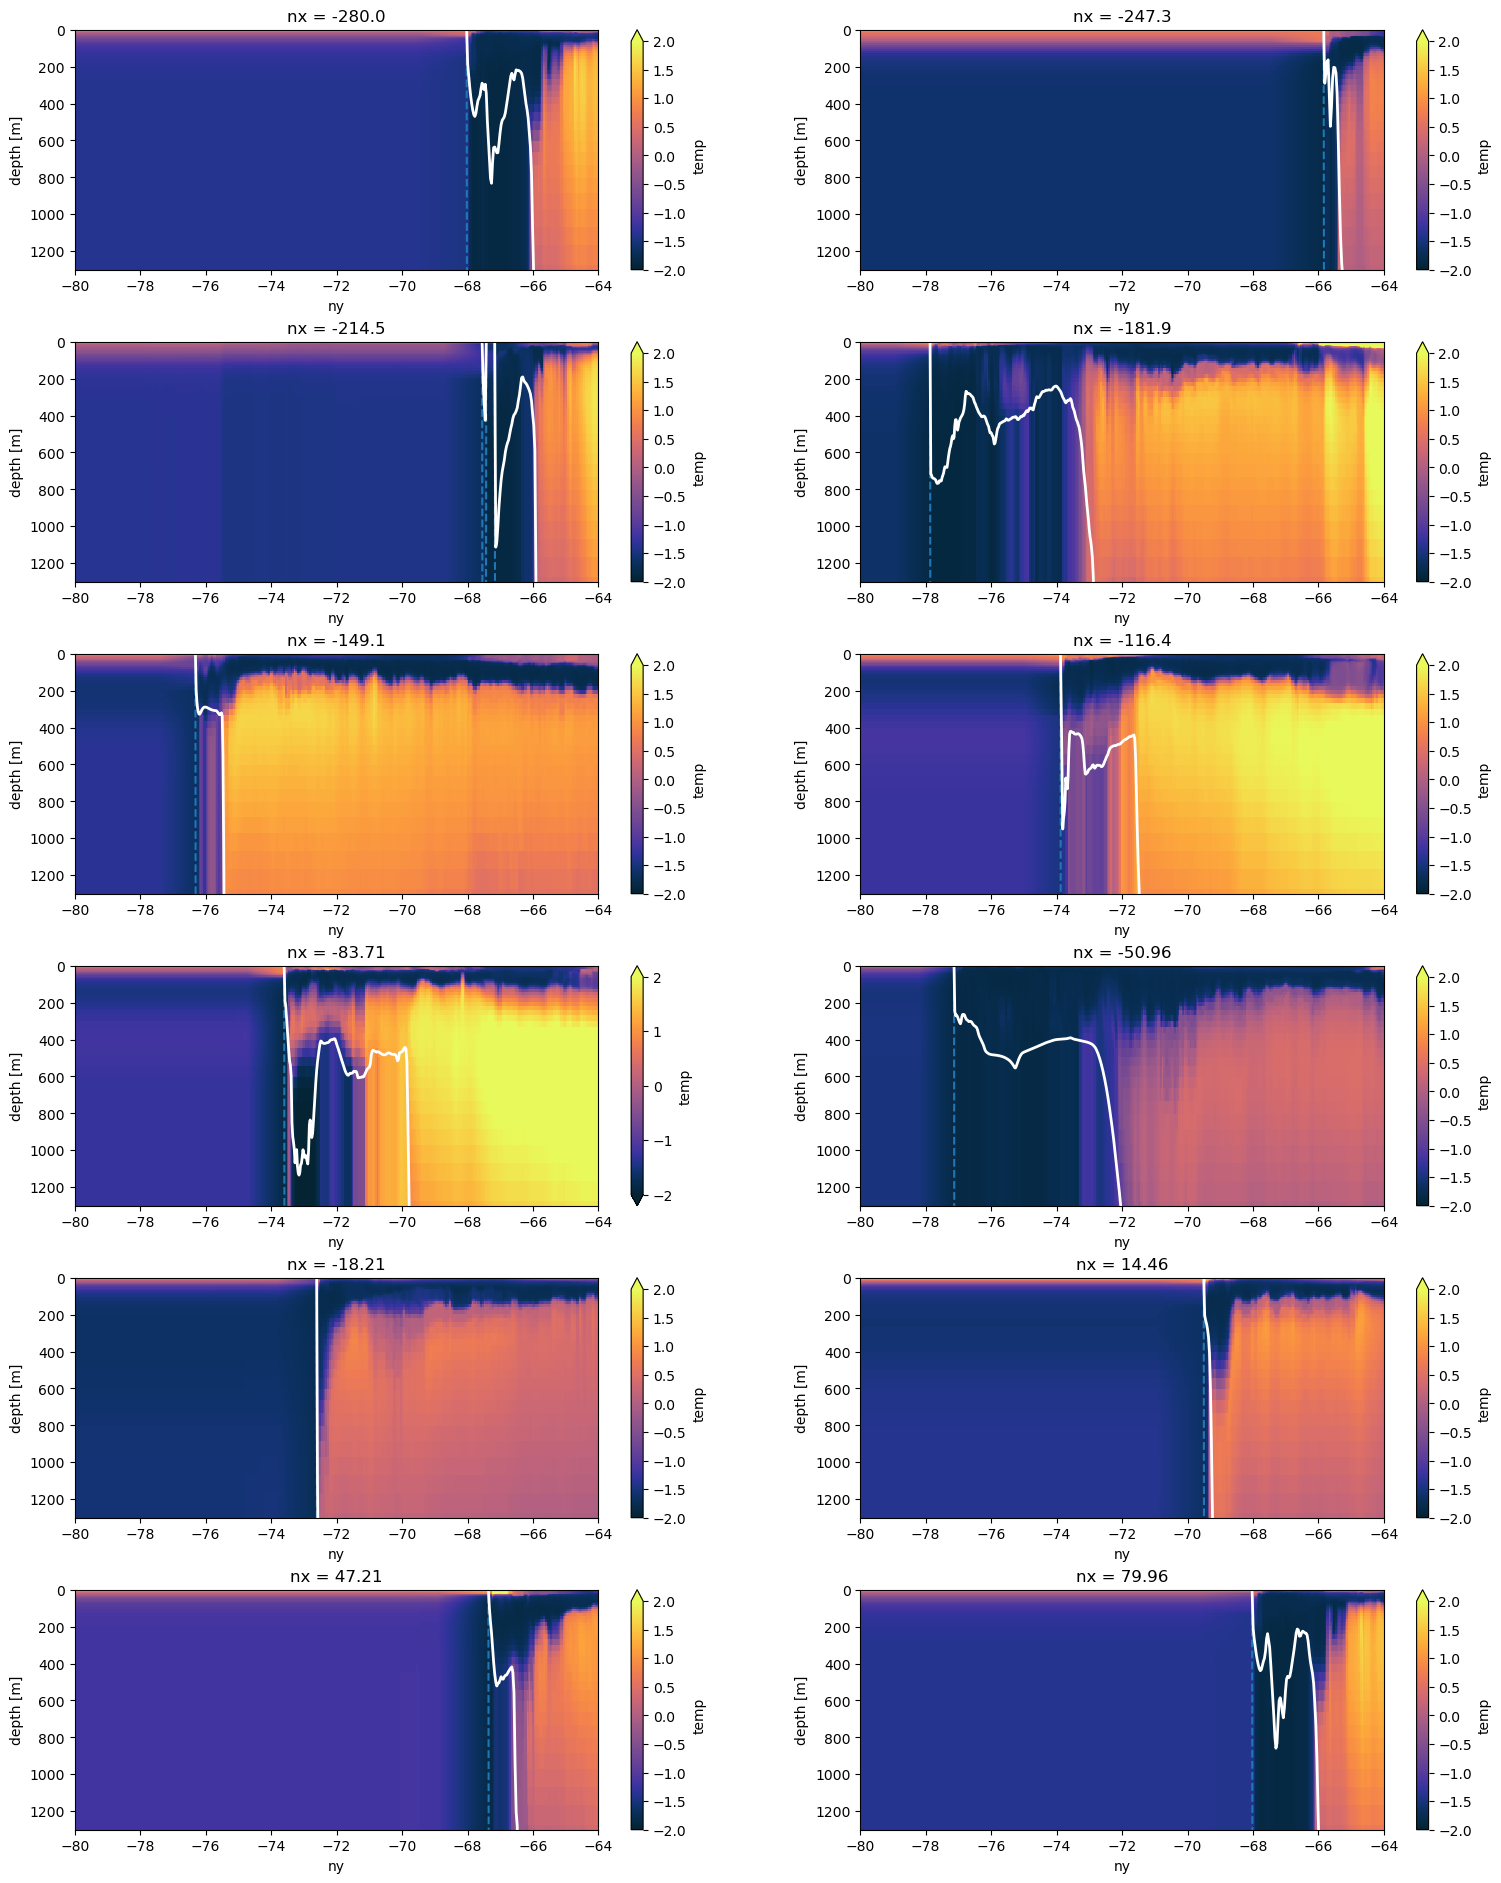

In [30]:
plt.figure(figsize=(16,20))
plt.subplots_adjust(left=0.05, right=0.95, 
                    top=0.95, bottom=0.05, 
                    wspace=0.2, hspace=0.3)

loopsize = 12
for k in range(loopsize):
    plt.subplot(6,2,k+1)
    transects_choice = np.linspace(0,4320-1,loopsize)
    transect_ind = int(transects_choice[k])
    panan01_IC_for_8km_smoothed.temp.isel(nxp=transect_ind).sel(nyp=lat_slice_forplot).plot(y='depth',cmap=cmo.thermal,vmin=-2,vmax=2)
    (5000*ocean_mask_target.isel(nxp=transect_ind)).plot(x='nyp',linestyle='--')
    ocean_topog_target.isel(nx=transect_ind).plot(x='ny',color='white',linewidth=2)
    plt.ylim(1300,0)
    plt.xlim(-80,-64)

transects with **non-smoothed data**

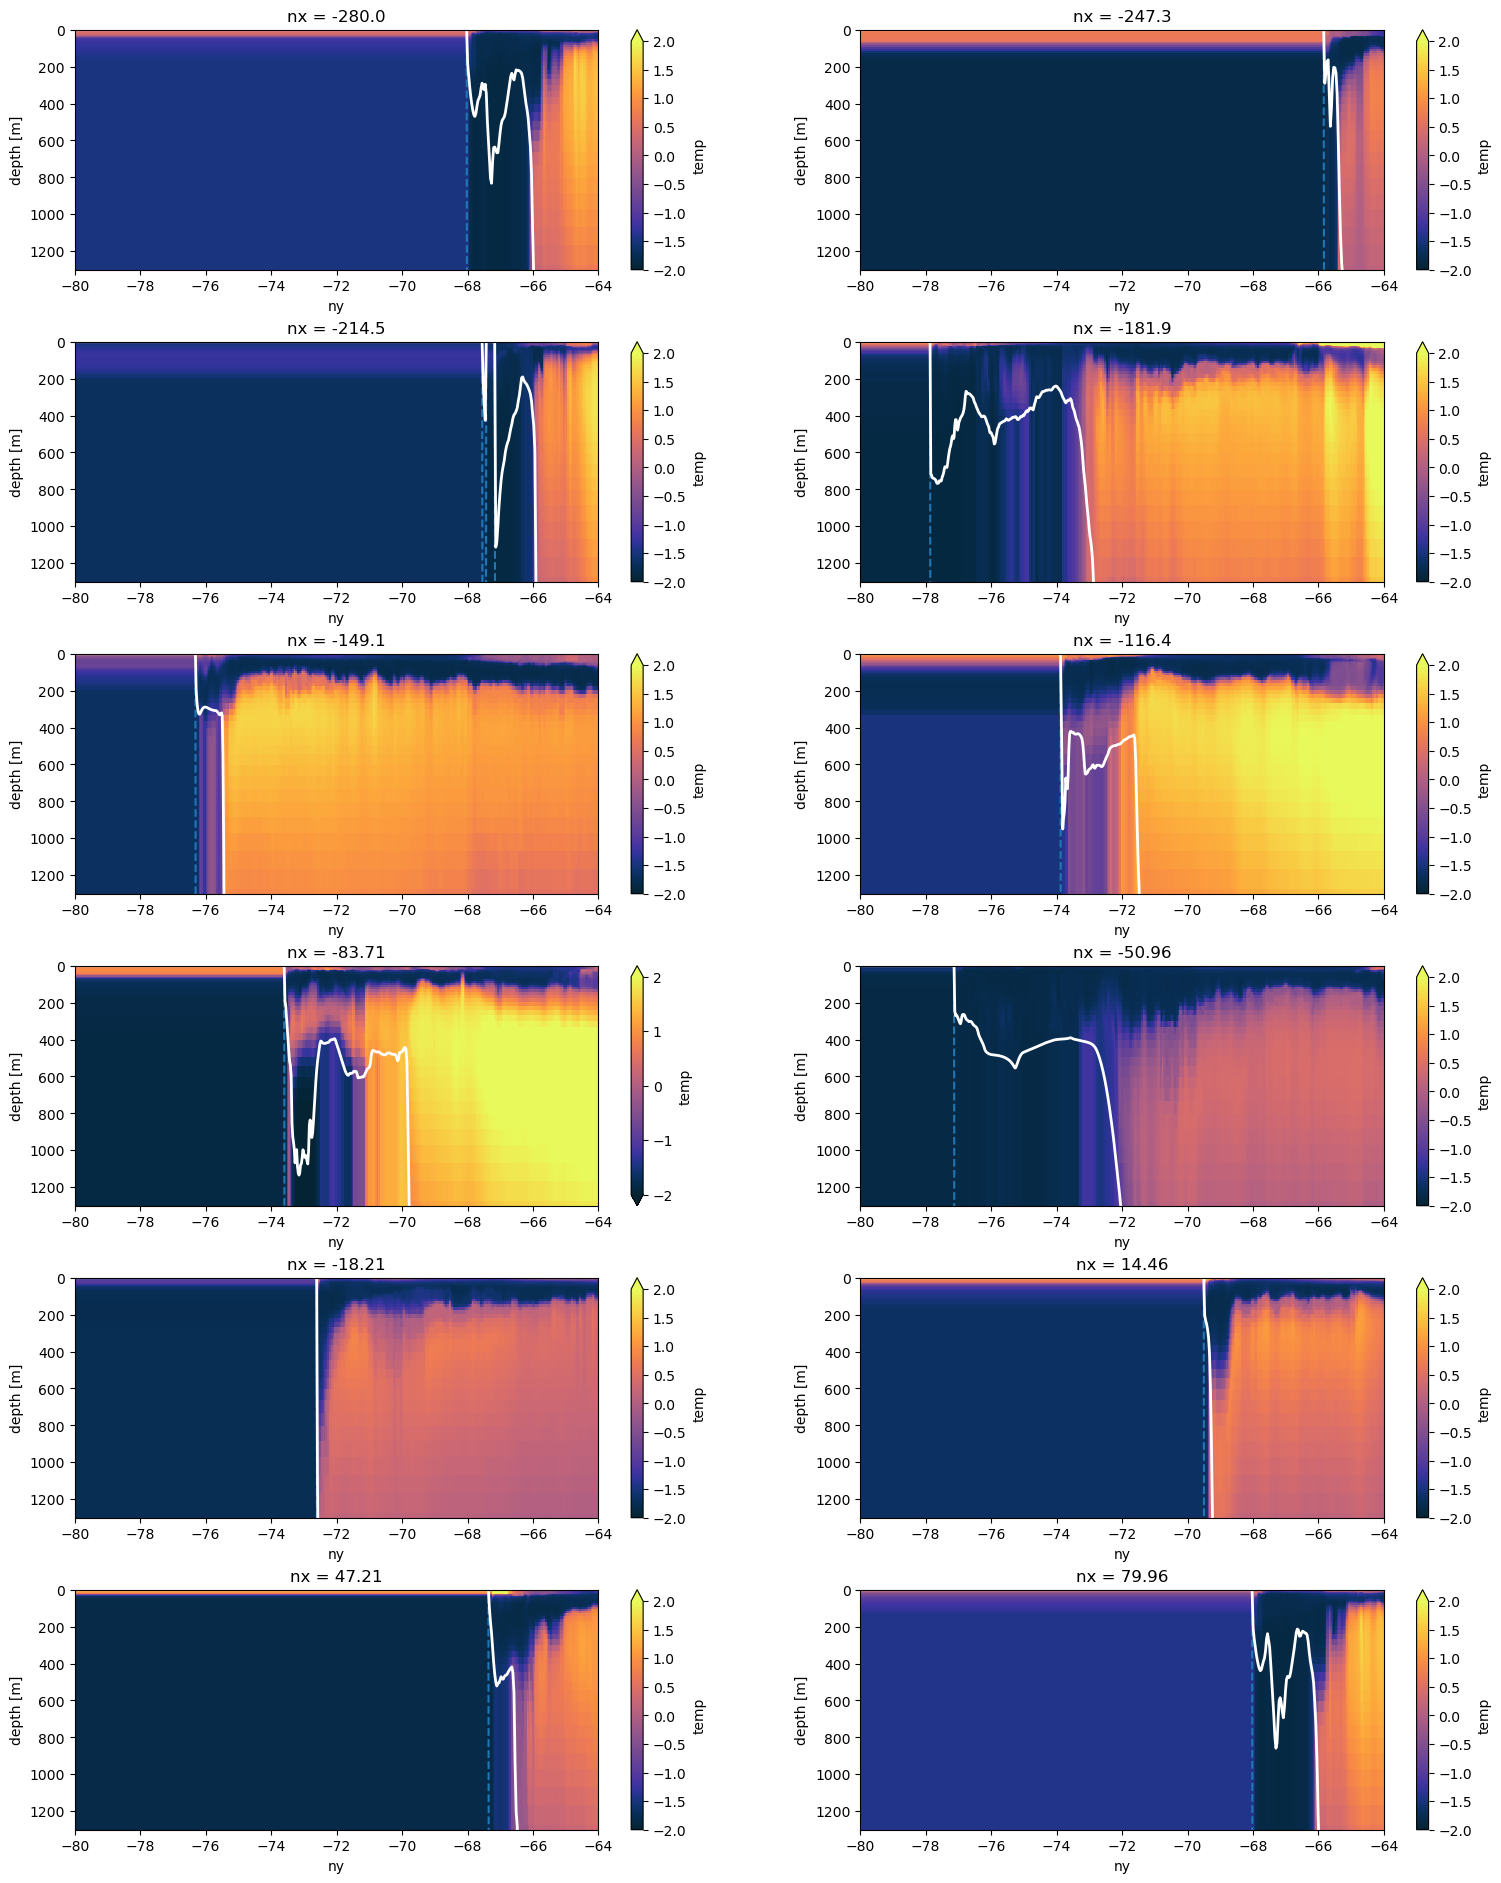

In [31]:
plt.figure(figsize=(16,20))
plt.subplots_adjust(left=0.05, right=0.95, 
                    top=0.95, bottom=0.05, 
                    wspace=0.2, hspace=0.3)

loopsize = 12
for k in range(loopsize):
    plt.subplot(6,2,k+1)
    transects_choice = np.linspace(0,4320-1,loopsize)
    transect_ind = int(transects_choice[k])
    panan01_IC_for_8km.temp.isel(nxp=transect_ind).sel(nyp=lat_slice_forplot).plot(y='depth',cmap=cmo.thermal,vmin=-2,vmax=2)
    (5000*ocean_mask_target.isel(nxp=transect_ind)).plot(x='nyp',linestyle='--')
    ocean_topog_target.isel(nx=transect_ind).plot(x='ny',color='white',linewidth=2)
    plt.ylim(1300,0)
    plt.xlim(-80,-64)

_____________________________________